In [1]:
import os
import random
import scipy
import shutil
from pathlib import Path
from PIL import Image, ImageDraw

# Step 1 Define PATH & change folder names


In [2]:
"""
dict structure:
├── annotations (Origin annotations)
├── annotations_COCO
├── Cityperson/leftImg8bit (Origin file)
└── cp (Model running file)
    ├── images
    │   ├── test (500)
    │   ├── train (2380)
    │   └── val (595)
    └── labels
        ├── test (500)
        ├── train (2380)
        └── val (595)
"""
# Root directory
ROOT = "./datasets"
# Annotation saving path
ANNO_DIR = os.path.join(ROOT, "annotations")
# COCO format annotation saving path
COCO_ANNO_DIR = os.path.join(ROOT, "annotations_COCO")

# Origin file path
ORIGIN_DIR = os.path.join(ROOT, "Cityperson/leftImg8bit")
SOURCE_TRAIN_DIR = os.path.join(ORIGIN_DIR, "train")
SOURCE_VAL_DIR = os.path.join(ORIGIN_DIR, "val")
# SOURCE_TEST_DIR = os.path.join(ORIGIN_DIR, "test")  # never used

# Target path of 'test' and 'val' split from 'train'
TARGET_DIR = os.path.join(ROOT, "cp")
TARGET_TRAIN_DIR = os.path.join(TARGET_DIR, "images/train")
TARGET_VAL_DIR = os.path.join(TARGET_DIR, "images/val")
TARGET_TEST_DIR = os.path.join(TARGET_DIR, "images/test")

TARGET_TRAIN_LABEL = os.path.join(TARGET_DIR, "labels/train")
TARGET_VAL_LABEL = os.path.join(TARGET_DIR, "labels/val")
TARGET_TEST_LABEL = os.path.join(TARGET_DIR, "labels/test")

# Proportion of 'val' split from 'train'
VAL_SET_PAR = 0.2

# Debug data set
DEBUG_SIZE_TRAIN = 40
DEBUG_SIZE_VAL = 20


anno_train_file_mat = "anno_train.mat"
anno_val_file_mat = "anno_val.mat"

# Define label names
city_person_label_list = [
    {"id": 0, "name": "ignore regions"},
    {"id": 1, "name": "pedestrians"},
    {"id": 2, "name": "riders"},
    {"id": 3, "name": "sitting persons"},
    {"id": 4, "name": "unusual postures"},
    {"id": 5, "name": "group of people"},
]

In [3]:
# Create new folders
Path(TARGET_TRAIN_DIR).mkdir(parents=True, exist_ok=True)
Path(TARGET_VAL_DIR).mkdir(parents=True, exist_ok=True)
Path(TARGET_TEST_DIR).mkdir(parents=True, exist_ok=True)
Path(TARGET_TRAIN_LABEL).mkdir(parents=True, exist_ok=True)
Path(TARGET_VAL_LABEL).mkdir(parents=True, exist_ok=True)
Path(TARGET_TEST_LABEL).mkdir(parents=True, exist_ok=True)

# Step 2 Load annotations (train_source & val_source)


In [4]:
anno_train_mat = scipy.io.loadmat(os.path.join(ANNO_DIR, anno_train_file_mat))
anno_val_mat = scipy.io.loadmat(os.path.join(ANNO_DIR, anno_val_file_mat))
anno_train_mat.keys()
anno_val_mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'anno_val_aligned'])

In [5]:
# Check some unnecessary elements
print(anno_train_mat["__header__"])
print(anno_train_mat["__version__"])
print(anno_train_mat["__globals__"])

b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue May 23 10:53:38 2017'
1.0
[]


In [6]:
# Flatten
anno_train_mat = anno_train_mat["anno_train_aligned"].flatten()
anno_val_mat = anno_val_mat["anno_val_aligned"].flatten()
print(
    f"train source set size = {anno_train_mat.shape}, test source set size = {anno_val_mat.shape}."
)
anno_train_mat[1]

train source set size = (2975,), test source set size = (500,).


array([[(array(['aachen'], dtype='<U6'), array(['aachen_000001_000019_leftImg8bit.png'], dtype='<U36'), array([[  0, 877, 383,  14,  26,   0, 877, 383,  14,  26],
               [  0, 878, 423,  15,  25,   0, 878, 423,  15,  25],
               [  0, 464, 439,  11,  10,   0, 464, 439,  11,  10],
               [  0,  65, 425,  32,  25,   0,  65, 425,  32,  25]], dtype=uint16))                                                                                ]],
      dtype=[('cityname', 'O'), ('im_name', 'O'), ('bbs', 'O')])

In [7]:
# Convert 'mat' format into 'list'
def unzip_annotation(data):
    datasets = []

    for cell in data:
        city_name, im_name, bbs = cell[0][0]
        bbs_new = []
        for each in bbs:
            class_label, x1, y1, w, h, instance_id, x1_vis, y1_vis, w_vis, h_vis = each
            bbs_new.append(
                {
                    "class_label": 0,
                    "x1": x1,
                    "y1": y1,
                    "w": w,
                    "h": h,
                    "instance_id": instance_id,
                    "x1_vis": x1_vis,
                    "y1_vis": y1_vis,
                    "w_vis": w_vis,
                    "h_vis": h_vis,
                }
            )
        # mistake in origin dataset
        if city_name[0] == "tuebingen":
            city_name[0] = "tubingen"
        datasets.append(
            {"city_name": city_name[0], "im_name": im_name[0], "bbs": bbs_new}
        )

    return datasets

In [8]:
train_source = unzip_annotation(anno_train_mat)
val_source = unzip_annotation(anno_val_mat)

In [9]:
print(len(train_source), len(val_source), type(train_source), type(val_source))
print(train_source[0])

2975 500 <class 'list'> <class 'list'>
{'city_name': 'aachen', 'im_name': 'aachen_000000_000019_leftImg8bit.png', 'bbs': [{'class_label': 0, 'x1': 892, 'y1': 445, 'w': 21, 'h': 53, 'instance_id': 24000, 'x1_vis': 892, 'y1_vis': 445, 'w_vis': 21, 'h_vis': 53}, {'class_label': 0, 'x1': 901, 'y1': 443, 'w': 34, 'h': 55, 'instance_id': 24001, 'x1_vis': 901, 'y1_vis': 443, 'w_vis': 34, 'h_vis': 55}, {'class_label': 0, 'x1': 1844, 'y1': 436, 'w': 44, 'h': 106, 'instance_id': 25000, 'x1_vis': 1844, 'y1_vis': 441, 'w_vis': 44, 'h_vis': 101}, {'class_label': 0, 'x1': 1025, 'y1': 215, 'w': 28, 'h': 34, 'instance_id': 0, 'x1_vis': 1025, 'y1_vis': 215, 'w_vis': 28, 'h_vis': 34}]}


1375
0 1157 384 9 21
0 1615 316 28 69
0 1538 327 39 94
0 1496 331 38 92
0 1638 330 35 84
0 1668 335 30 74
0 1205 347 33 80
0 372 398 13 16
0 639 359 13 8
0 955 404 15 15


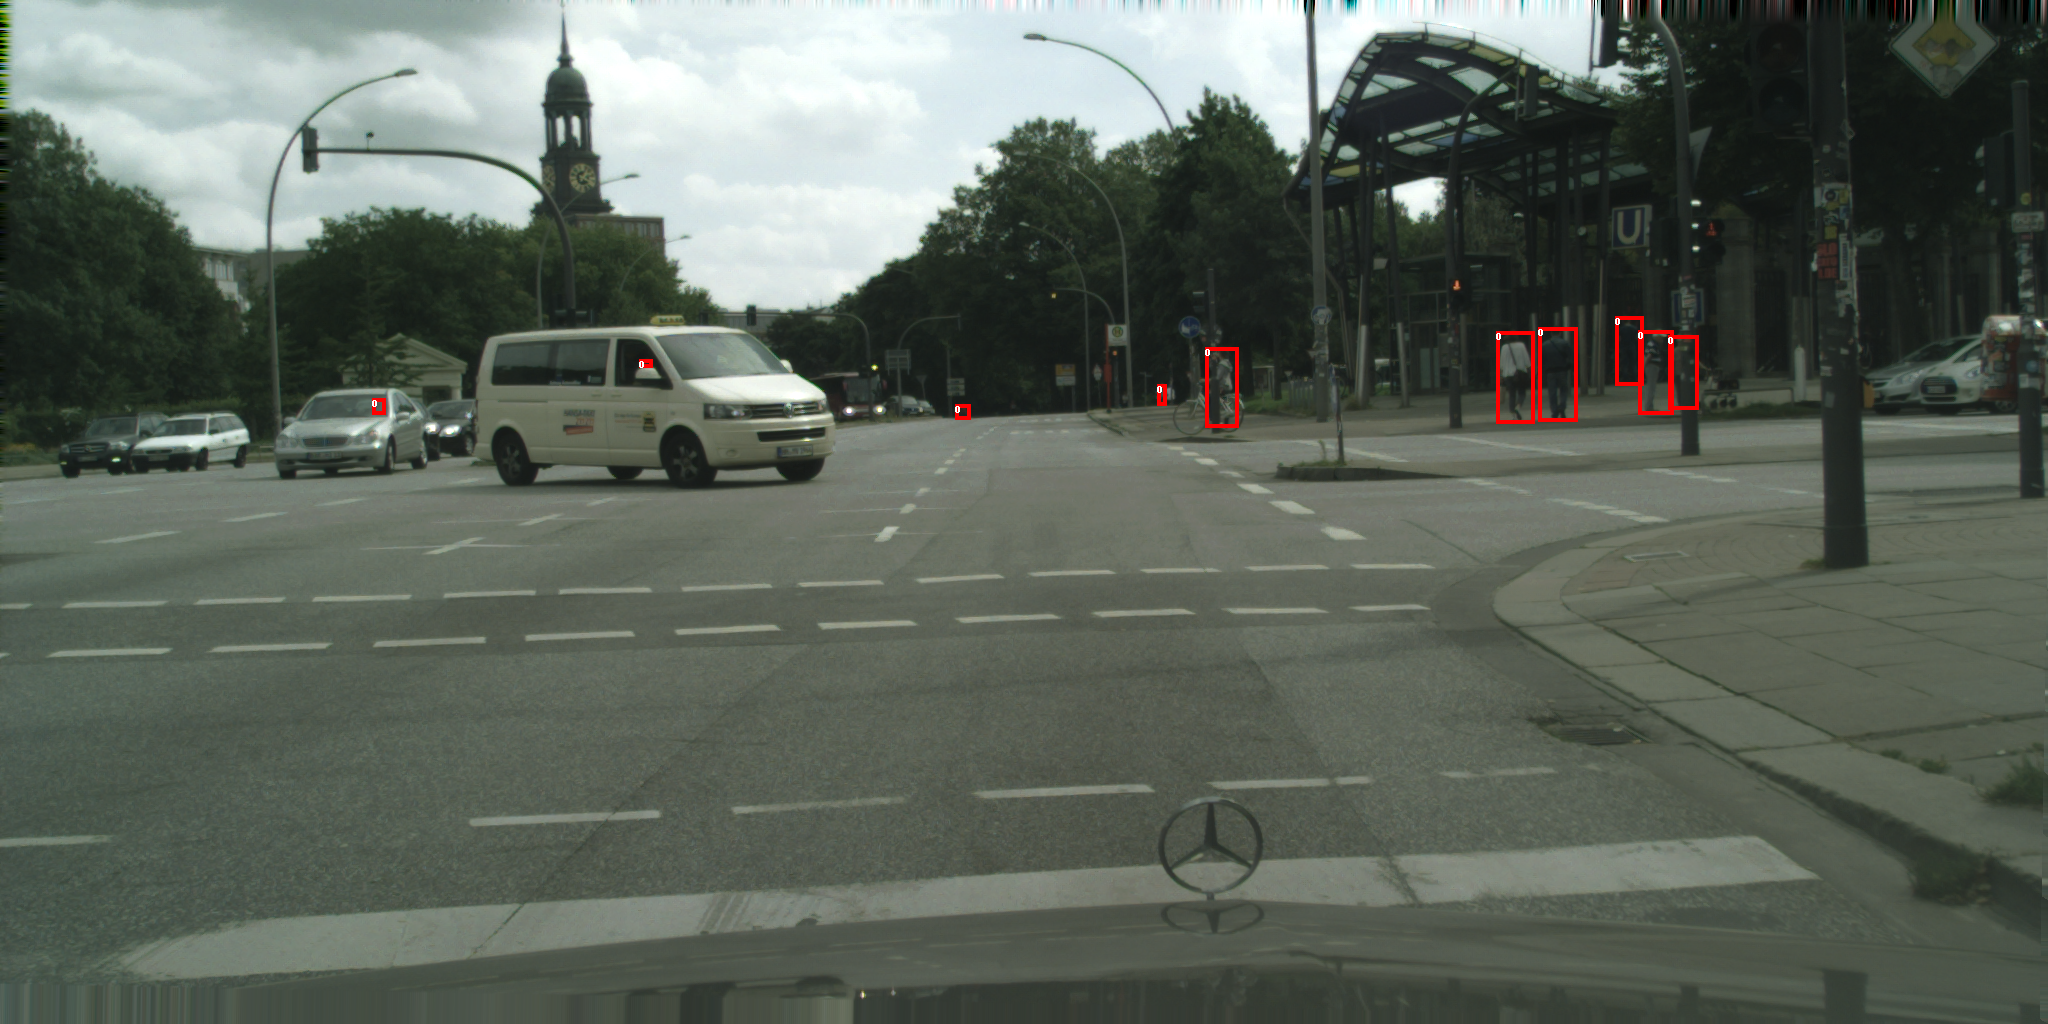

In [21]:
rand_index = random.randint(0, len(train_source))
print(rand_index)

city_name = train_source[rand_index]["city_name"]
im_name = train_source[rand_index]["im_name"]
im_path = os.path.join(SOURCE_TRAIN_DIR, city_name, im_name)

image = Image.open(im_path)

draw = ImageDraw.Draw(image, "RGBA")

for box in train_source[rand_index]["bbs"]:
    class_idx = box["class_label"]
    x, y, w, h = box["x1"], box["y1"], box["w"], box["h"]
    print(class_idx, x, y, w, h)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=4)
    text = str(class_idx)
    draw.text(xy=(x, y), text=text, fill="white")

image

# Randomly split train_source into 'train' and 'val'


In [11]:
# Split proportionally
# random.seed(int(42))
# random.shuffle(train_source)

# split_index = int(VAL_SET_PAR * len(train_source))
# val_split = train_source[:split_index]
# train_split = train_source[split_index:]
# test_split = val_source

# print(len(train_split), len(val_split), len(test_split))

train_split = train_source
val_split = val_source

In [12]:
for item in train_split:
    source_path = os.path.join(SOURCE_TRAIN_DIR, item["city_name"], item["im_name"])
    target_path = os.path.join(TARGET_TRAIN_DIR, item["im_name"])
    if os.path.isfile(source_path):
        shutil.copy(source_path, target_path)
    else:
        print("ERROR:", source_path, target_path)

for item in val_split:
    source_path = os.path.join(SOURCE_VAL_DIR, item["city_name"], item["im_name"])
    target_path = os.path.join(TARGET_VAL_DIR, item["im_name"])
    if os.path.isfile(source_path):
        shutil.copy(source_path, target_path)
    else:
        print("ERROR:", source_path, target_path)

# for item in test_split:
#     source_path = os.path.join(SOURCE_VAL_DIR, item["city_name"], item["im_name"])
#     target_path = os.path.join(TARGET_TEST_DIR, item["im_name"])
#     if os.path.isfile(source_path):
#         shutil.copy(source_path, target_path)
#     else:
#         print("ERROR:", source_path, target_path)

In [13]:
# Check for every image
train_count = 0
val_count = 0
test_count = 0
for item in train_split:
    target_path = os.path.join(TARGET_TRAIN_DIR, item["im_name"])
    if not os.path.isfile(target_path):
        print("ERROR:", target_path)
    train_count += 1
for item in val_split:
    target_path = os.path.join(TARGET_VAL_DIR, item["im_name"])
    if not os.path.isfile(target_path):
        print("ERROR:", target_path)
    val_count += 1
# for item in test_split:
#     target_path = os.path.join(TARGET_TEST_DIR, item["im_name"])
#     if not os.path.isfile(target_path):
#         print("ERROR:", target_path)
#     test_count += 1

print(train_count, val_count, test_count)

2975 500 0


# Convert labels into txt files


In [14]:
def convert2txt(data, img_dir, label_dir):
    for item in data:
        image_path = os.path.join(img_dir, item["im_name"])
        if not os.path.isfile(target_path):
            print("ERROR:", target_path)

        img = Image.open(image_path)
        img_width, img_height = img.size

        label_lines = []
        for bbs in item["bbs"]:
            upperleft_x, upperleft_y, width, height = (
                bbs["x1"],
                bbs["y1"],
                bbs["w"],
                bbs["h"],
            )
            center_x = upperleft_x + width / 2
            center_y = upperleft_y + height / 2

            center_x = str(round(center_x / img_width, 6))
            center_y = str(round(center_y / img_height, 6))
            width = str(round(width / img_width, 6))
            height = str(round(height / img_height, 6))

            label_lines.append(
                " ".join([str(bbs["class_label"]), center_x, center_y, width, height])
            )

        label_dst = os.path.join(label_dir, item["im_name"].split(".")[0] + ".txt")
        with open(label_dst, "w") as file:
            file.write("\n".join(label_lines))

In [15]:
convert2txt(train_split, TARGET_TRAIN_DIR, TARGET_TRAIN_LABEL)
convert2txt(val_split, TARGET_VAL_DIR, TARGET_VAL_LABEL)
# convert2txt(test_split, TARGET_TEST_DIR, TARGET_TEST_LABEL)

# Output


In [27]:
import json


anno_files_path = "datasets/annotations/val_gt.json"
PREDICT_DIR = os.path.join(TARGET_DIR, "predict")
Path(PREDICT_DIR).mkdir(parents=True, exist_ok=True)
output_path = "YOLOv8/runs/detect/predict/labels"

with open(anno_files_path) as f:
    anno_test = json.load(f)
anno_test["images"]

[{'id': 1,
  'im_name': 'frankfurt_000000_000294_leftImg8bit.png',
  'height': 1024,
  'width': 2048},
 {'id': 2,
  'im_name': 'frankfurt_000000_000576_leftImg8bit.png',
  'height': 1024,
  'width': 2048},
 {'id': 3,
  'im_name': 'frankfurt_000000_001016_leftImg8bit.png',
  'height': 1024,
  'width': 2048},
 {'id': 4,
  'im_name': 'frankfurt_000000_001236_leftImg8bit.png',
  'height': 1024,
  'width': 2048},
 {'id': 5,
  'im_name': 'frankfurt_000000_001751_leftImg8bit.png',
  'height': 1024,
  'width': 2048},
 {'id': 6,
  'im_name': 'frankfurt_000000_002196_leftImg8bit.png',
  'height': 1024,
  'width': 2048},
 {'id': 7,
  'im_name': 'frankfurt_000000_002963_leftImg8bit.png',
  'height': 1024,
  'width': 2048},
 {'id': 8,
  'im_name': 'frankfurt_000000_003025_leftImg8bit.png',
  'height': 1024,
  'width': 2048},
 {'id': 9,
  'im_name': 'frankfurt_000000_003357_leftImg8bit.png',
  'height': 1024,
  'width': 2048},
 {'id': 10,
  'im_name': 'frankfurt_000000_003920_leftImg8bit.png',
  'he

In [28]:
mr_list = []
for file_name in os.listdir(output_path):
    print(file_name)
    for each in anno_test["images"]:
        if each["im_name"].split(".")[0] == file_name.split(".")[0]:
            id = each["id"]
            height = each["height"]
            width = each["width"]
            print(id)
            break

    with open(os.path.join(output_path, file_name)) as file:
        lines = [line.rstrip() for line in file]
        print(lines)
    for annotation in lines:
        (
            category,
            center_x_r,
            center_y_r,
            width_rate,
            height_rate,
            score,
        ) = annotation.split(" ")
        mr_list.append(
            {
                "image_id": id,
                "category_id": int(category),
                "bbox": [
                    round(float(center_x_r) * width)
                    - round(float(width_rate) * width / 2),
                    round(float(center_y_r) * height)
                    - round(float(height_rate) * height / 2),
                    round(float(width_rate) * width),
                    round(float(height_rate) * height),
                ],
                "score": float(score),
            }
        )
mr_list[0]

frankfurt_000000_000294_leftImg8bit.txt
1
['1 0.575896 0.416762 0.0187736 0.0899008 0.826657', '1 0.605453 0.413924 0.0183476 0.0886808 0.801005', '1 0.591116 0.412703 0.016809 0.0833718 0.793095', '1 0.465848 0.410908 0.00805092 0.0403177 0.35665']
frankfurt_000000_000576_leftImg8bit.txt
2
['1 0.593949 0.408565 0.0245569 0.118467 0.869147', '1 0.0056529 0.440544 0.0107957 0.127227 0.29154']
frankfurt_000000_001016_leftImg8bit.txt
3
['1 0.733989 0.424876 0.0539589 0.26612 0.900359', '1 0.373343 0.434212 0.046198 0.229518 0.887519', '1 0.464631 0.430931 0.0298643 0.143183 0.88072', '1 0.580911 0.406655 0.0144996 0.0725828 0.317579']
frankfurt_000000_001236_leftImg8bit.txt
4
['1 0.338317 0.420627 0.0221573 0.104857 0.850211', '1 0.630355 0.404655 0.0167408 0.084501 0.79554', '1 0.493148 0.397046 0.0169795 0.0850859 0.753733', '1 0.401957 0.405987 0.0136679 0.0676464 0.731707', '1 0.255374 0.405188 0.0138937 0.0686166 0.671799', '1 0.278841 0.407422 0.01193 0.0596039 0.644355', '1 0.26065

{'image_id': 1,
 'category_id': 1,
 'bbox': [1160, 381, 38, 92],
 'score': 0.826657}

In [24]:
len(mr_list)

3298

In [29]:
jsonlist = json.dumps({"annotations": mr_list})
with open("predict.json", "w") as f:
    f.write(jsonlist)

In [20]:
with open("custom_prediction_300.json") as f:
    anno_300 = json.load(f)
len(anno_300)

150000